In [23]:
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import operator
import ast
from tqdm import tqdm
import networkx as nx
import pandas as pd
import collections
import random
from mpl_toolkits.basemap import Basemap

# For importing functions
import ipynb
import sys  

# Import data
sys.path.insert(0, 'C:/Users/Owner/Documents/Thesis/Code/Season_Analysis/Extraction_Partitioning_Functions')

from ipynb.fs.full.Data_Extraction_Functions import three_month_extraction,five_month_extraction,extract_region_lists
# Import partitioning functions
from ipynb.fs.full.Partitioning_Functions import regional_ordinal_sequence,block_ordinal_sequence

sys.path.insert(0,'C:/Users/Owner/Documents/Thesis/Code/Season_Analysis/Proxy_Permutation_Entropy')
from ipynb.fs.full.Proxy_Permutation_Entropy_Functions import permutation_tree, kinda_entropy

sys.path.insert(0,'C:/Users/Owner/Documents/Thesis/Code/Season_Analysis/Co_Occurrence')
from ipynb.fs.full.Co_Occurrence_Functions import derived_coupling_strength, ordpat_strings

# Data 

In [24]:
## Import data

three_month = extract_region_lists(three_month=True)
djf_dates = three_month[0]
jja_dates = three_month[1]
three_monthly = three_month[2:]

five_month = extract_region_lists(three_month=False)
ndjfm_dates = five_month[0]
mjjas_dates = five_month[1]
five_monthly = five_month[2:]

names = ['NWAus', 'NEAus', 'MC', 'IO', 'EEP', 'ISM', 'EASM']
regions = [i for i in range(7)]

DJF/JJA Order: DJF_dates,JJA_dates,nw,ne,mc,ioo,eep,ism,easm
Length of time series with minor temporal irregularities: 753
Number of missing months: 21
Length of time series with no temporal irregularities: 720
NDJFM/MJJAS Order: NDJFM_dates,MJJAS_dates,nw,ne,mc,ioo,eep,ism,easm


In [25]:
permutation_names = []
for i,j in itertools.combinations(regions,2):
    string = f'{names[i]} & {names[j]}'
    permutation_names.append(string)

In [26]:
years = []
for i in range(len(ndjfm_dates)):
    date = ndjfm_dates[i]
    year = date[-4:]
    years.append(int(year))
years_5 = years[::5]

In [27]:
patterns_5 = ordpat_strings(five_monthly,5,1,block=True)

In [28]:
def co_occur(region1,region2):
    N = len(region1) # Since length of all ordinal sequences are the same 
    
    co_occur_join = []
    for i in range(N):
        #joined = region1[i] + region2[i]
        joined = (region1[i],region2[i])
        co_occur_join.append(joined)
    
    return co_occur_join

def count_frequency(input_list,highest_freq=True):
    '''
    Count frequency of each unique element in input_list
    '''
    freq = {} # Create empty dictionary
    for item in input_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
    if highest_freq==True:
        return dict(sorted(freq.items(),key = operator.itemgetter(1),reverse=True))
    else:
        return freq

In [29]:
def chunked_ord_seq(ordinal_sequence_region_1,
                    ordinal_sequence_region_2,
                    window_length,
                    block_length,
                    co_occurring_threshold=1):
    '''
    Calculate the number of co-occurring patterns. Note the assumpt
    
    Inputs:
        1) ordinal_sequence_region_1 = ordinal sequence corresponding to region 1 (the result of regional_ordinal_sequence() or block_ordinal_sequence())
        2) ordinal_sequence_region_2 = ordinal sequence corresponding to region 2
        3) window_length = ordinal partition window length, D corresponding to the sequence above
        4) co_occurrence_threshold = threshold for a co-occurring pattern to be prescribed, default = 1
        5) block_length = length of the sub-sample of ordinal sequence to derive coupling strength temporally
    '''
    region_1_split = []
    region_2_split = []
    for i in range(len(ordinal_sequence_region_1)): ## TO DO: FIND GENERAL FORM FOR THE LENGTH OF THE ADMISSIBLE PATTERN
        lower_bound = i
        upper_bound = i+block_length
        
        chain_1 = ordinal_sequence_region_1[lower_bound:upper_bound]
        chain_2 = ordinal_sequence_region_2[lower_bound:upper_bound]
        
        if len(chain_1)==len(chain_2) == block_length:
            region_1_split.append(list(chain_1))
            region_2_split.append(list(chain_2))
        else:
            break
    return np.asarray(region_1_split),np.asarray(region_2_split)

# NEW CONSTRUCTION

In [30]:
def order_permutations(original_pattern,order):
    all_perm_dict = permutation_tree(original_pattern)
    filtered_list = [ast.literal_eval(k) for k,v in all_perm_dict.items() if v==order]
    return filtered_list

In [31]:
all_permutations = list(permutation_tree([0,1,2,3,4]).keys())

list_of_perms = []
for i in range(len(all_permutations)):
    permutation = all_permutations[i]
    
    order_1_permutations = [str(i) for i in order_permutations(ast.literal_eval(permutation),1)]
    order_1_permutations.append(permutation)
    order_1_permutations = [i.replace(',','') for i in order_1_permutations]

    list_of_perms.append(order_1_permutations)

In [32]:
list_of_perms

[['[1 0 2 3 4]', '[0 2 1 3 4]', '[0 1 3 2 4]', '[0 1 2 4 3]', '[0 1 2 3 4]'],
 ['[0 1 2 3 4]', '[1 2 0 3 4]', '[1 0 3 2 4]', '[1 0 2 4 3]', '[1 0 2 3 4]'],
 ['[2 0 1 3 4]', '[0 1 2 3 4]', '[0 2 3 1 4]', '[0 2 1 4 3]', '[0 2 1 3 4]'],
 ['[1 0 3 2 4]', '[0 3 1 2 4]', '[0 1 2 3 4]', '[0 1 3 4 2]', '[0 1 3 2 4]'],
 ['[1 0 2 4 3]', '[0 2 1 4 3]', '[0 1 4 2 3]', '[0 1 2 3 4]', '[0 1 2 4 3]'],
 ['[2 1 0 3 4]', '[1 0 2 3 4]', '[1 2 3 0 4]', '[1 2 0 4 3]', '[1 2 0 3 4]'],
 ['[0 1 3 2 4]', '[1 3 0 2 4]', '[1 0 2 3 4]', '[1 0 3 4 2]', '[1 0 3 2 4]'],
 ['[0 1 2 4 3]', '[1 2 0 4 3]', '[1 0 4 2 3]', '[1 0 2 3 4]', '[1 0 2 4 3]'],
 ['[0 2 1 3 4]', '[2 1 0 3 4]', '[2 0 3 1 4]', '[2 0 1 4 3]', '[2 0 1 3 4]'],
 ['[2 0 3 1 4]', '[0 3 2 1 4]', '[0 2 1 3 4]', '[0 2 3 4 1]', '[0 2 3 1 4]'],
 ['[2 0 1 4 3]', '[0 1 2 4 3]', '[0 2 4 1 3]', '[0 2 1 3 4]', '[0 2 1 4 3]'],
 ['[3 0 1 2 4]', '[0 1 3 2 4]', '[0 3 2 1 4]', '[0 3 1 4 2]', '[0 3 1 2 4]'],
 ['[1 0 3 4 2]', '[0 3 1 4 2]', '[0 1 4 3 2]', '[0 1 3 2 4]', '[

In [33]:
test_nw_dict = {}
test_ne_dict = {}

nw_pattern = patterns_5[0][0] # [04132]
ne_pattern = patterns_5[1][0]  #[12034]

for j in range(len(list_of_perms)):
    supernode = list_of_perms[j]
    if nw_pattern in supernode:
        num_nw = 1
        test_nw_dict[j] = num_nw
    if ne_pattern in supernode:
        num_ne = 1
        test_ne_dict[j] = num_ne
    
    else:
        pass
print(f'NW pattern: {nw_pattern}',test_nw_dict)
print(f'NE pattern: {ne_pattern}',test_ne_dict)

NW pattern: [4 0 2 3 1] {66: 1, 67: 1, 88: 1, 102: 1, 104: 1}
NE pattern: [1 2 0 3 4] {1: 1, 5: 1, 14: 1, 15: 1, 16: 1}


In [36]:
def static_full_dictionary(ord_seq_1,ord_seq_2,threshold):
    co_occurring = co_occur(ord_seq_1,ord_seq_2)
    
    co_occurring_dict = {}
    for k in range(len(co_occurring)):
        pattern_1 = co_occurring[k][0]
        pattern_2 = co_occurring[k][1]
        
        for i in range(len(list_of_perms)):
            supernode_1 = list_of_perms[i]     
            for j in range(len(list_of_perms)):
                supernode_2 = list_of_perms[j]
                
                if pattern_1 in supernode_1 and pattern_2 in supernode_2:
                    co_occurring_tuple = tuple(('A'+str(i),'B'+str(j)))
                    if (co_occurring_tuple in co_occurring_dict):
                        co_occurring_dict[co_occurring_tuple] += 1
                    else:
                        co_occurring_dict[co_occurring_tuple] = 1
                else:
                    pass
    co_occurring_dict = {k:v for k,v in co_occurring_dict.items() if v>=threshold}
    
    return co_occurring_dict

In [37]:
static_full_dictionary(patterns_5[0],patterns_5[1],1)

{('A66', 'B1'): 11,
 ('A66', 'B5'): 1,
 ('A66', 'B14'): 1,
 ('A66', 'B15'): 1,
 ('A66', 'B16'): 2,
 ('A67', 'B1'): 9,
 ('A67', 'B5'): 1,
 ('A67', 'B14'): 1,
 ('A67', 'B15'): 1,
 ('A67', 'B16'): 2,
 ('A88', 'B1'): 9,
 ('A88', 'B5'): 3,
 ('A88', 'B14'): 2,
 ('A88', 'B15'): 2,
 ('A88', 'B16'): 4,
 ('A102', 'B1'): 3,
 ('A102', 'B5'): 1,
 ('A102', 'B14'): 1,
 ('A102', 'B15'): 1,
 ('A102', 'B16'): 2,
 ('A104', 'B1'): 23,
 ('A104', 'B5'): 4,
 ('A104', 'B14'): 3,
 ('A104', 'B15'): 2,
 ('A104', 'B16'): 5,
 ('A27', 'B0'): 49,
 ('A27', 'B4'): 44,
 ('A27', 'B7'): 23,
 ('A27', 'B10'): 21,
 ('A27', 'B13'): 17,
 ('A28', 'B0'): 64,
 ('A28', 'B4'): 61,
 ('A28', 'B7'): 32,
 ('A28', 'B10'): 29,
 ('A28', 'B13'): 28,
 ('A47', 'B0'): 115,
 ('A47', 'B4'): 102,
 ('A47', 'B7'): 58,
 ('A47', 'B10'): 43,
 ('A47', 'B13'): 46,
 ('A69', 'B0'): 111,
 ('A69', 'B4'): 93,
 ('A69', 'B7'): 40,
 ('A69', 'B10'): 41,
 ('A69', 'B13'): 31,
 ('A70', 'B0'): 102,
 ('A70', 'B4'): 96,
 ('A70', 'B7'): 50,
 ('A70', 'B10'): 45,
 ('A7

In [38]:
vals = []
for i,j in tqdm(itertools.combinations(regions,2)):
    nwne_all = static_full_dictionary(patterns_5[i],patterns_5[j],1)
    nwne_vals = sorted(list(nwne_all.values()))
    vals.append(nwne_vals)

21it [00:11,  1.86it/s]


In [40]:
def temporal_evolution(ord_seq_1,ord_seq_2,block_length,threshold):
    temporal_co_occur = chunked_ord_seq(ord_seq_1,ord_seq_2,5,block_length)
    
    strengths = []
    for i in tqdm(range(len(temporal_co_occur[0]))):
        region_1 = temporal_co_occur[0][i]
        region_2 = temporal_co_occur[1][i]
    
        co_occurring_dict = {}
        for k in range(len(region_1)):
            nw_pattern = region_1[k]
            ne_pattern = region_2[k]
            
            for i in range(len(list_of_perms)):
                supernode_nw = list_of_perms[i]     
                for j in range(len(list_of_perms)):
                    supernode_ne = list_of_perms[j]
                    
                    if nw_pattern in supernode_nw and ne_pattern in supernode_ne:
                        co_occurring_tuple = tuple((i,j))
                        if (co_occurring_tuple in co_occurring_dict):
                            co_occurring_dict[co_occurring_tuple] += 1
                        else:
                            co_occurring_dict[co_occurring_tuple] = 1
                    else:
                        pass
        filtered_dict = {k:v for k,v in co_occurring_dict.items() if v>=threshold}
        strengths.append(len(filtered_dict)/(math.factorial(5)))
    
    return strengths

In [41]:
nw_ne_temporal = temporal_evolution(patterns_5[0],patterns_5[1],30,1)

test = chunked_ord_seq(patterns_5[0],patterns_5[1],5,30)
strenf = []
for i in range(len(test[0])):
    thing = len(count_frequency(co_occur(test[0][i],test[1][i])))
    strenf.append(thing)

100%|████████████████████████████████████████████████████████████████████████████████| 211/211 [00:15<00:00, 13.82it/s]


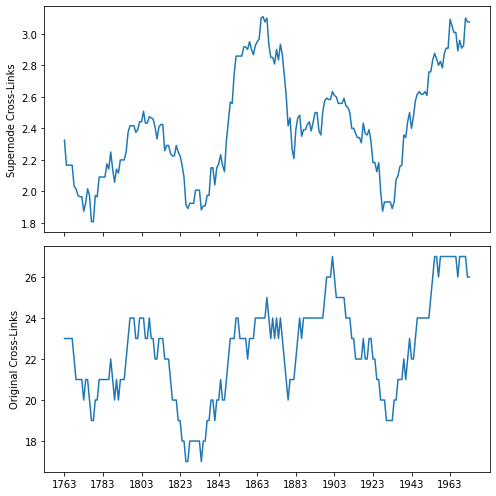

In [42]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7,7),sharex=True)
axs[0].plot(years_5[:-30+1],nw_ne_temporal)
axs[0].set_ylabel('Supernode Cross-Links')
axs[1].plot(years_5[:-30+1],strenf)
axs[1].set_xticks(years_5[:-30+1:20])
axs[1].set_ylabel('Original Cross-Links')
#axs[1].axvline(years_5[167],linestyle='--',c='red',label='1930')
#axs[1].legend(bbox_to_anchor=(1.25,0.5))
fig.tight_layout();

In [180]:
block_length = 30
threshold = [1,2,5,10]

# standardise scores so they are more visible
all_regions_supernodes = []
for i,j in itertools.combinations(regions,2):
    regional_thresholds = []
    for k in range(len(threshold)):
        thresh = threshold[k]
        test = np.asarray(temporal_evolution(patterns_5[i],patterns_5[j],block_length,thresh))
        
        #test_standardised = (test - min(test))/(max(test) - min(test))
        #regional_thresholds.append(test_standardised)
        
        regional_thresholds.append(test)
        
    all_regions_supernodes.append(regional_thresholds)

100%|████████████████████████████████████████████████████████████████████████████████| 211/211 [00:16<00:00, 12.90it/s]


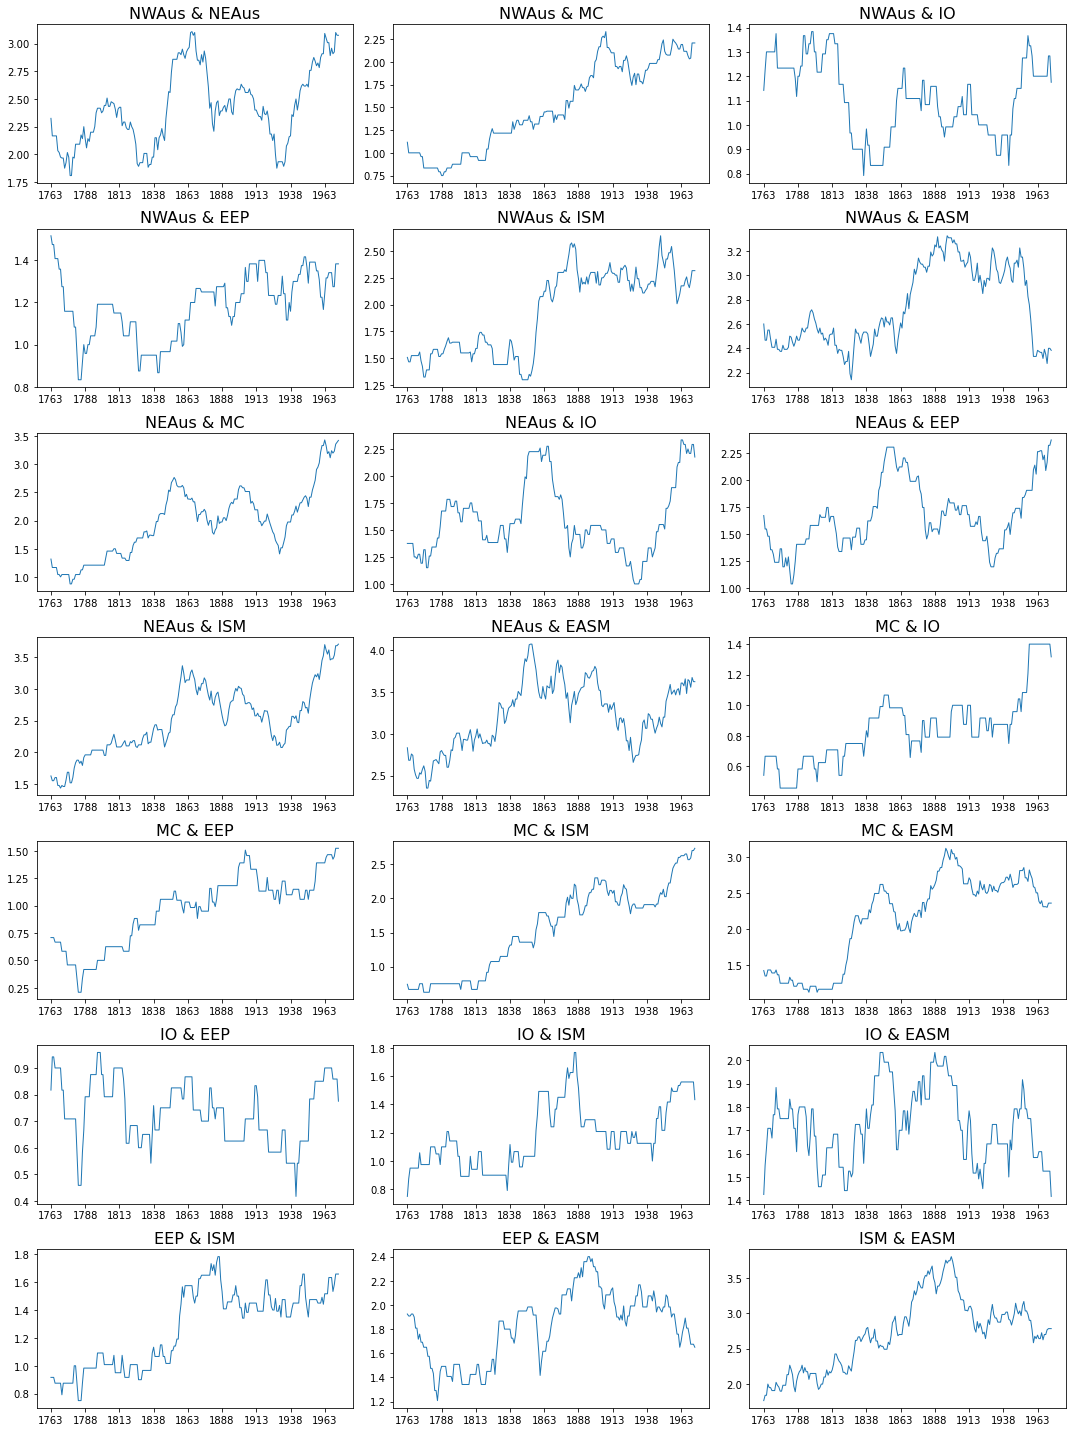

In [190]:
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(15,20))
axs = axs.ravel()
for i in range(len(all_regions_supernodes)):

    axs[i].plot(years_5[:-30+1], all_regions_supernodes[i][0],linewidth=1)
    axs[i].set_xticks(years_5[:-30+1:25],rotation=0)
    
    #axs[i].set_ylim(bottom=0)
    axs[i].set_title(permutation_names[i], fontsize=16)
    
    #axs[i].fill_between([years_5[17],years_5[77]],[max(all_regions_supernodes[i][0]),max(all_regions_supernodes[i][0])],color='grey',alpha=0.5,label='Dalton Minimum (1780-1840)' if i==0 else "")
    #axs[i].fill_between([years_5[47],years_5[56]],[max(all_regions_supernodes[i][0]),max(all_regions_supernodes[i][0])],color='red',alpha=0.2,label='Cold Decade (1810-1819)' if i==1 else "")
    #axs[i].fill_between([years_5[167],years_5[181]],[max(all_regions_supernodes[i][0]),max(all_regions_supernodes[i][0])],color='blue',alpha=0.2,label= 'High Indonesian \nVolcanic Activity (1930-1944)' if i==1 else "")
    
fig.tight_layout()

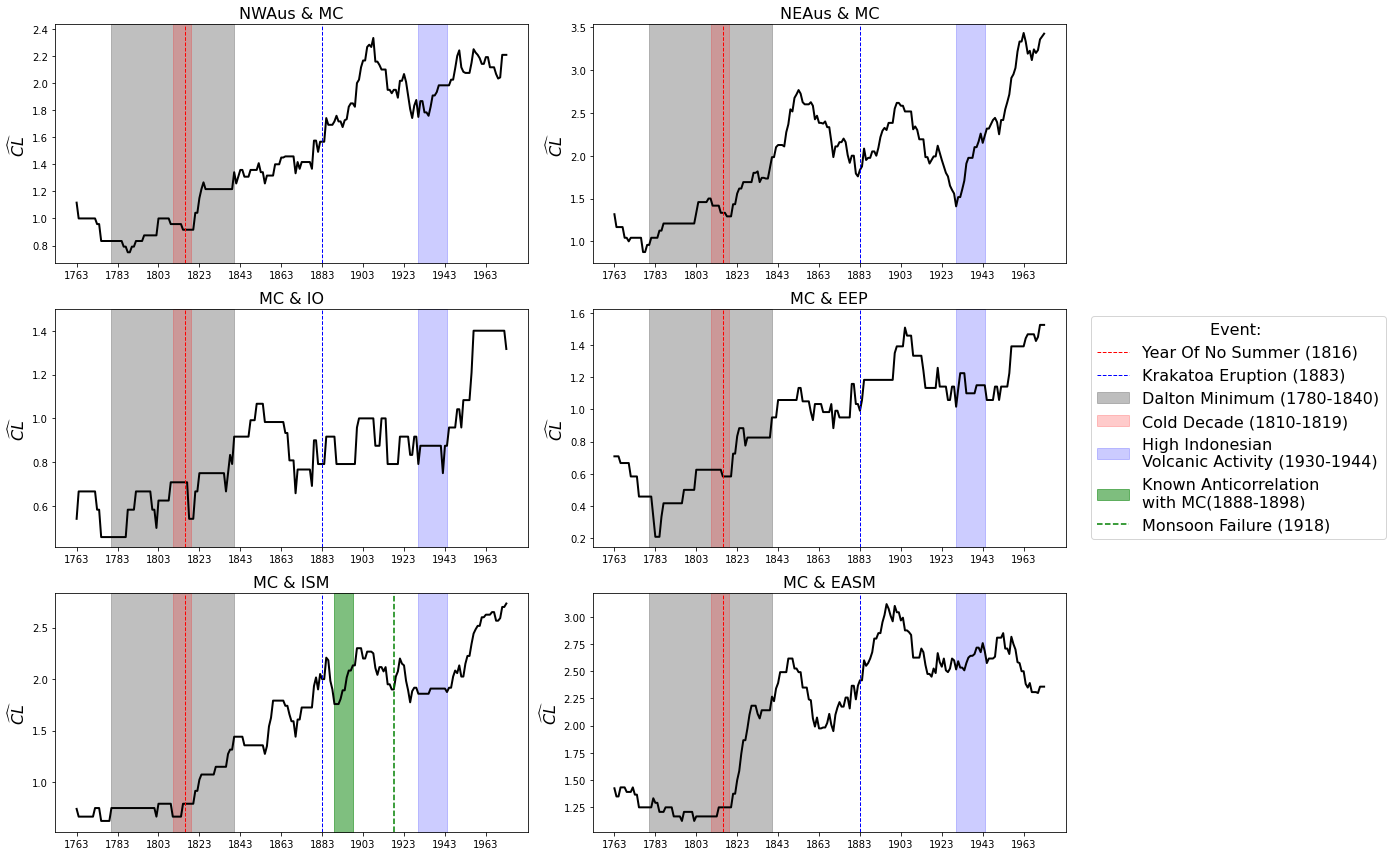

In [232]:
varying_mc = operator.itemgetter(1,6,11,12,13,14)(all_regions_supernodes)
permutation_mc = operator.itemgetter(1,6,11,12,13,14)(permutation_names)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,12))
axs = axs.ravel()
for i in range(len(varying_mc)):
    axs[i].plot(years_5[:-30+1], 
                varying_mc[i][0],linewidth=2,c='k')
    axs[i].set_xticks(years_5[:-block_length+1:20],rotation=0)
    #axs[i].set_xlim(left=1810)
    axs[i].set_ylim(top=max(varying_mc[i][0])+0.1)
    
    axs[i].set_title(permutation_mc[i], fontsize=16)
    axs[i].set_ylabel(r'$\widehat{CL}$',  fontsize=16)

    #axs[i].axvline(years_5[142],
    #               c='k',
    #               linestyle='--',
    #               linewidth=1,
    #               label='Santa Maria Eruption (1903)' if i==0 else "")
    axs[i].axvline(years_5[53],
                   c='red',
                   linestyle='--',
                   linewidth=1,
                   label='Year Of No Summer (1816)' if i==0 else "")
    axs[i].axvline(years_5[120],
                   c='blue',
                   linestyle='--',
                   linewidth=1,
                   label='Krakatoa Eruption (1883)' if i==0 else "")
    
    axs[i].fill_between([years_5[17],years_5[77]],
                        [max(varying_mc[i][0])+0.1,max(varying_mc[i][0])+0.1],
                        color='grey',
                        alpha=0.5,
                        label='Dalton Minimum (1780-1840)' if i==0 else "")
    axs[i].fill_between([years_5[47],years_5[56]],
                        [max(varying_mc[i][0])+0.1,max(varying_mc[i][0])+0.1],
                        color='red',
                        alpha=0.2,
                        label='Cold Decade (1810-1819)' if i==1 else "")
    axs[i].fill_between([years_5[167],years_5[181]],
                        [max(varying_mc[i][0])+0.1,max(varying_mc[i][0])+0.1],
                        color='blue',
                        alpha=0.2,
                        label= 'High Indonesian \nVolcanic Activity (1930-1944)' if i==1 else "")
    
    if i == 4:
        axs[i].fill_between([years_5[126],years_5[135]],
                            [max(varying_mc[i][0])+0.1,max(varying_mc[i][0])+0.1],
                            color='green',
                            alpha=0.5,
                            label='Known Anticorrelation \nwith MC(1888-1898)')
        #axs[i].axvline(years_5[136],c='red',linestyle='--')
        #axs[i].axvline(years_5[139],c='red',linestyle='--')
        #axs[i].axvline(years_5[142],c='red',linestyle='--')
        axs[i].axvline(years_5[155],c='green',linestyle='--',label='Monsoon Failure (1918)')
        #axs[i].axvline(years_5[157],c='red',linestyle='--')
        
legend = fig.legend(title='Event: ', loc='center',bbox_to_anchor=(1.15,0.5),fontsize=16,title_fontsize=16,fancybox=True)
fig.tight_layout()
